In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm.notebook import tqdm

In [6]:
from collections import Counter

# Load Data
Gazeta.ru is our best dataset for now

In [3]:
gazeta = pd.read_csv('newsviz/data/processed/gazeta.csv.gz')

In [4]:
gazeta.head()

,date,topics,lemmatized
0,2008-11-21 15:19:14,Бизнес,госдума принять первое чтение целое поправка з...
1,2012-09-27 10:54:51,Наука,японский учёный физический центр riken заявлят...
2,2015-12-01 15:28:45,Армия,россия готовиться расширить военный операция с...
3,2013-04-18 16:42:06,Новости,египет ждать российский турист гарантировать и...
4,2012-09-26 13:54:13,Политика,в ростовский область депутат гордума новочерка...


In [29]:
gazeta.dropna(inplace=True)

In [30]:
gazeta.shape

(865844, 3)

# Evaluate topic distribution

In [7]:
cntr = Counter(gazeta['topics'].values)

<BarContainer object of 12 artists>

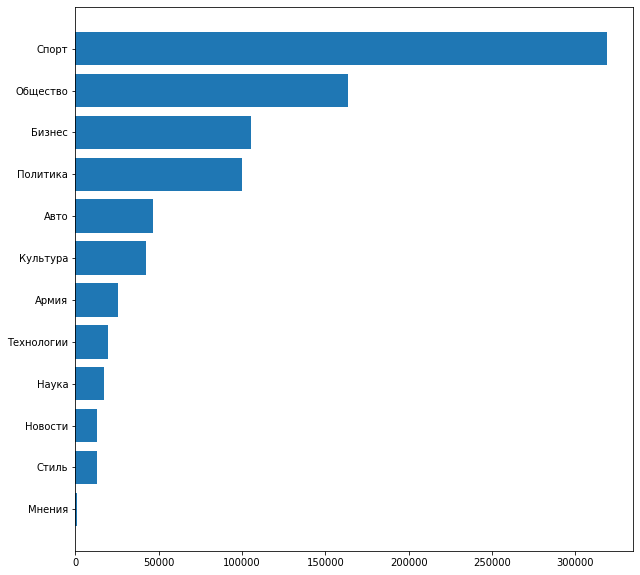

In [13]:
ticks, lenghts = zip(*reversed(cntr.most_common()))
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(cntr)), lenghts, tick_label=ticks
        )

# Preprocessing

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
%%time
tfidf = TfidfVectorizer(lowercase=False, analyzer='word')
feats = tfidf.fit_transform(gazeta['lemmatized'].values)

CPU times: user 1min 11s, sys: 1.04 s, total: 1min 12s
Wall time: 1min 12s


In [19]:
feats.shape

(865844, 1114246)

In [20]:
type(feats)

scipy.sparse.csr.csr_matrix

# Classification

In [27]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

Filter topics by frequency

In [22]:
selected_topics = [t for t, c in cntr.most_common() if c > 100000]

In [23]:
selected_topics

['Спорт', 'Общество', 'Бизнес', 'Политика']

DIY label encoding

In [24]:
le = {w: i for i, w in enumerate(selected_topics)}

label "4" is for the rest

In [31]:
target = gazeta['topics'].apply(lambda x: le.get(x, 4)).values

In [32]:
%%time
model = RidgeClassifier()
res = cross_val_score(model, feats, target, cv=5)
print(res)
print(np.mean(res))

[0.83830247 0.81680324 0.82059145 0.85298177 0.81382819]
0.8285014221115674
CPU times: user 39min 5s, sys: 42min 56s, total: 1h 22min 2s
Wall time: 24min 42s


In [34]:
%%time
model = RidgeClassifier(normalize=True)
preds = cross_val_predict(model, feats, target, cv=5)

CPU times: user 12min 16s, sys: 12min 59s, total: 25min 15s
Wall time: 7min 54s


In [35]:
labels = [l for l, v in le.items()]
labels.append('Другое')

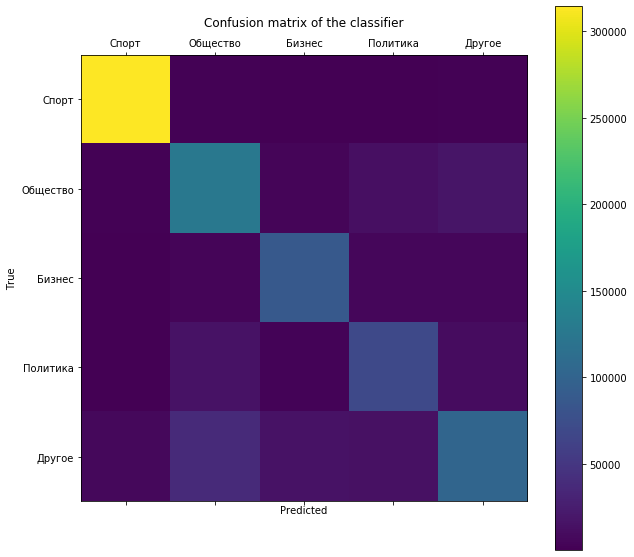

In [38]:
cm = confusion_matrix(target, preds)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
r = classification_report(target, preds)
print(r)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    318908
           1       0.68      0.77      0.72    163388
           2       0.79      0.84      0.81    105386
           3       0.68      0.69      0.68    100214
           4       0.74      0.58      0.65    177948

    accuracy                           0.81    865844
   macro avg       0.77      0.77      0.77    865844
weighted avg       0.81      0.81      0.81    865844



Good enough

In [40]:
le

{'Спорт': 0, 'Общество': 1, 'Бизнес': 2, 'Политика': 3}

In [41]:
le['Другое'] = 4

# Dump all

In [42]:
%%time
model = RidgeClassifier()
model.fit(feats, target)

CPU times: user 10min 12s, sys: 9min 41s, total: 19min 53s
Wall time: 6min 49s


In [43]:
import joblib

In [50]:
import json

In [47]:
joblib.dump(model, 'newsviz/models/gazeta.bin')
joblib.dump(tfidf, 'newsviz/models/gazeta_tfidf.bin')

['/home/sv9t/repas/forks/newsviz/models/gazeta_tfidf.bin']

In [48]:
classnames = {name: label for label, name in le.items()}

In [49]:
classnames

{0: 'Спорт', 1: 'Общество', 2: 'Бизнес', 3: 'Политика', 4: 'Другое'}

In [51]:
path = 'newsviz/models/classnames_gazeta.json'

In [52]:
json.dump(classnames, open(path, "w"))